In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

In [2]:
os.getcwd()

'/files'

# Weather Data

In [8]:
#Import weather data and drop utc timezone
weather = pd.read_csv("Group_Project/data/weather.csv")
weather.drop(columns = "timestamp_utc", inplace = True)
#Rename timestamp_cet feature into Timestamp
weather.rename(columns = {"timestamp_cet": 'Timestamp'}, inplace = True)
#Show data
weather

,Timestamp,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
0,2007-04-22T21:20:00+02:00,18.9,15.2,1.6,0.7,0.7,321,18.9,973.5,0.0,4.4,3.0,38.0,405.94
1,2007-04-22T21:30:00+02:00,18.1,15.2,1.3,0.8,0.8,346,18.1,973.7,0.0,4.8,3.0,41.0,405.94
2,2007-04-22T21:40:00+02:00,17.7,15.1,0.9,0.2,0.2,4,17.7,973.7,0.0,5.1,3.0,43.0,405.94
3,2007-04-22T21:50:00+02:00,17.6,15.3,0.6,0.1,0.1,235,17.6,973.8,0.0,5.7,3.0,45.0,405.94
4,2007-04-22T22:00:00+02:00,17.4,15.4,0.7,0.3,0.3,178,17.4,973.9,0.0,6.3,3.0,48.0,405.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909575,2024-11-18T15:30:00+01:00,10.9,11.7,4.2,1.7,1.7,213,9.4,968.9,0.0,3.3,54.0,60.0,405.86
909576,2024-11-18T15:40:00+01:00,10.8,11.7,4.5,1.9,1.9,281,9.2,968.9,0.0,3.5,43.0,61.0,405.86
909577,2024-11-18T15:50:00+01:00,10.6,11.7,4.8,1.7,1.7,272,8.9,968.9,0.0,3.5,27.0,62.0,405.86
909578,2024-11-18T16:00:00+01:00,10.5,11.7,4.3,1.1,1.1,274,9.4,968.9,0.0,3.5,31.0,62.0,405.86


In [4]:
#Filter for only 2024 Data and see if there are missing values
weather_filtered = weather[weather["Timestamp"] >= "2024-01-01"].reset_index()
weather_filtered.drop(columns = "index", inplace = True)
weather_filtered.isna().sum()

Timestamp                  0
air_temperature            0
water_temperature          0
wind_gust_max_10min        0
wind_speed_avg_10min       0
wind_force_avg_10min       0
wind_direction             0
windchill                  0
barometric_pressure_qfe    0
precipitation              0
dew_point                  0
global_radiation           0
humidity                   0
water_level                0
dtype: int64

### UTC and timezone considerations
The Dataset weather.csv accounts for the change to Daylight Saving Time, which occurs the 31th of March at 01 : 50 : 00 in the morning. The observation following this value for Timestamp skips an hour, thereby jumping directly to the time 03: 00 : 00. Hence, we have a missing hour the 31th of March 2024 between 2 and 3 o'clock in the morning. 
On the other hand, the return to the Wintertime in October should cause the clock to go back one hour and we would therefore expect to have a backward jump in time the 27th of October 2024 at 2 o'clock in the morning. However, this is not the case in the Dataset, where the value for Timestamp presents no such shifts and repetitions of the same time values during the night of the 27th of October.
We suspect that the observations for the hour previous to the moment where the change from Daylight Saving Time to Wintertime occurs has been deleted to avoid repeting observations that have the same value for Timestamp, thereby allowing the observations following the timeshift to follow up the observations that were actually recorded an hour prior to them.

The Hardbruecke Dataset, coming from the same source, also behaves in this way. We can thereby merge them together without fearing a mismatch of observations when dealing with this time shifts.

In [5]:
#Get rid of the UTC format and adjust values of Timestamp to Greenwhich local time
weather_filtered['Timestamp'] = pd.to_datetime(weather_filtered['Timestamp'], utc=True)

#Readjust values of Timestamp for Zürich Timezone
weather_filtered["Timestamp"] = weather_filtered["Timestamp"]+pd.Timedelta(hours=1)
weather_filtered['Timestamp'] = weather_filtered['Timestamp'].dt.tz_localize(None)

### Obtain observations in Weather Dataframe every five minutes
As of now, the weather_filtered Dataframe we have so far contains observations every 10 minutes. However, the other Dataset we will later merge on, has observations separated by an interval of 5 minutes. We can obtain observations every 5 minutes for the weather data as well by duplicating each row. We thereby assume that weather conditions are not changing in a significant way within five minutes and it is therefore acceptable to use the same values for the meteorological features when restricting the time interval between observations to five minutes.

In [6]:
# Duplicate rows
duplicated_weather = pd.concat([weather_filtered, weather_filtered])

# Sort by timestamp to ensure new observations are put where they should be
duplicated_weather = duplicated_weather.sort_values(by='Timestamp').reset_index(drop=True)

# Add 5 minutes to every second row's timestamp
duplicated_weather.loc[1::2, 'Timestamp'] += pd.Timedelta(minutes=5)
duplicated_weather.rename(columns = {3: "wind_gust_max", 4: "wind_speed_avg", 5: "wind_force_avg"}, inplace = True)
five_weather = duplicated_weather

### Dealing with missing observations in the Weather Dataset

In [7]:
# Generate a full range of timestamps from the first to the last timestamp, at 5-minute intervals
full_range = pd.date_range(start=five_weather['Timestamp'].min(), end=five_weather['Timestamp'].max(), freq='5T')

# Find the missing timestamps by comparing with the existing ones
missing_timestamps = full_range[~full_range.isin(five_weather['Timestamp'])]

#Create a dataframe for missing timestamps
missing_timestamps = pd.DataFrame(missing_timestamps)
missing_timestamps.rename(columns = {0: 'Timestamp'}, inplace = True)

# concatenate missing timestamps to weather data
healed_weather = pd.concat([five_weather, missing_timestamps], ignore_index=True)

# Sort by timestamp to put missing observations where they should be
healed_weather = healed_weather.sort_values(by='Timestamp').reset_index(drop=True)

#Interpolate missing values
weather_features = healed_weather.columns
weather_features = weather_features[1:]

#iterate interpolation for missing values for all features
for i in weather_features:
    ff = healed_weather[i].ffill()
    bf = healed_weather[i].bfill()
    
    healed_weather[i] = healed_weather[i].fillna((ff + bf)/2)

# Hardbruecke Data

In [8]:
#Import hardbruecke data to copy date
df = pd.read_csv("Group_Project/data/frequenzen_hardbruecke_2024.csv")
# Transform the smaller dataset to wide format
df_wide = df.pivot_table(
    index="Timestamp", columns= "Name", values=["In", "Out"]).reset_index()

#We just need TimeStamp and Inflow for the Ost-VBZ Total and West-WBZ Total
#Selecting columns that we need 
relevant_columns = [('Timestamp', ''), ('In', 'Ost-VBZ Total'), ('In', 'West-VBZ total')]
df_VBZ = df_wide[relevant_columns]

#Filter for only 2024 Data
df_VBZ[df_VBZ["Timestamp"] >= '2024-01-01 00:00:00']

#Get rid of Multiindexing for practicality
df_VBZ = df_VBZ.droplevel(level=0, axis=1)
df_VBZ.rename(columns = {'':'Timestamp'}, inplace = True)

#Converting Timestamp features into datetime format
df_VBZ['Timestamp'] = pd.to_datetime(df_VBZ['Timestamp'])

## Dealing with missing observations in the Hardbruecke Dataset

In [9]:
# Generate a full range of timestamps from the first to the last timestamp, at 5-minute intervals
full_range = pd.date_range(start=df_VBZ['Timestamp'].min(), end=df_VBZ['Timestamp'].max(), freq='5T')

# Find the missing timestamps in df_VBZ by comparing with full_range
missing_timestamps = full_range[~full_range.isin(df_VBZ['Timestamp'])]

# Reshape the missing_timestamps a bit
missing_timestamps = pd.DataFrame(missing_timestamps)
missing_timestamps.rename(columns = {0: 'Timestamp'}, inplace = True)

### Daylight Saving time - considerations
Given the change to the Daylight Saving time which we discussed previously (which occurs the 31th of March 2024), all values for Timestamp that are comprised between the values 2024-03-31 01 : 50 : 00 and 2024-03-31 03 : 00 : 00 are going to be considered missing, although this timehole is actually not really a problem, since it is caused by the shift in time. However, to guarantee that we have equidistant observations we are going to consider these observations as missing as well, so that we can put values for them as well and obtained a cleaned time series with equidistant datapoints.

In [10]:
# Create a new healed dataset where missing timestamps are added
healed_VBZ = pd.concat([df_VBZ, missing_timestamps], ignore_index=True)

# Sort by Timestamp to ensure that missing Timestamps are inserted where they should be
healed_VBZ = healed_VBZ.sort_values(by='Timestamp').reset_index(drop=True)

### Missing values
There aren't just missing observations (Rows) in the Dataset, but also missing values within rows that exist. We are interested in visualizing where these missing values are located and if they follow a sistemic pattern or not.

Text(0.5, 1.0, 'Inflow of passengers at West-VBZ')

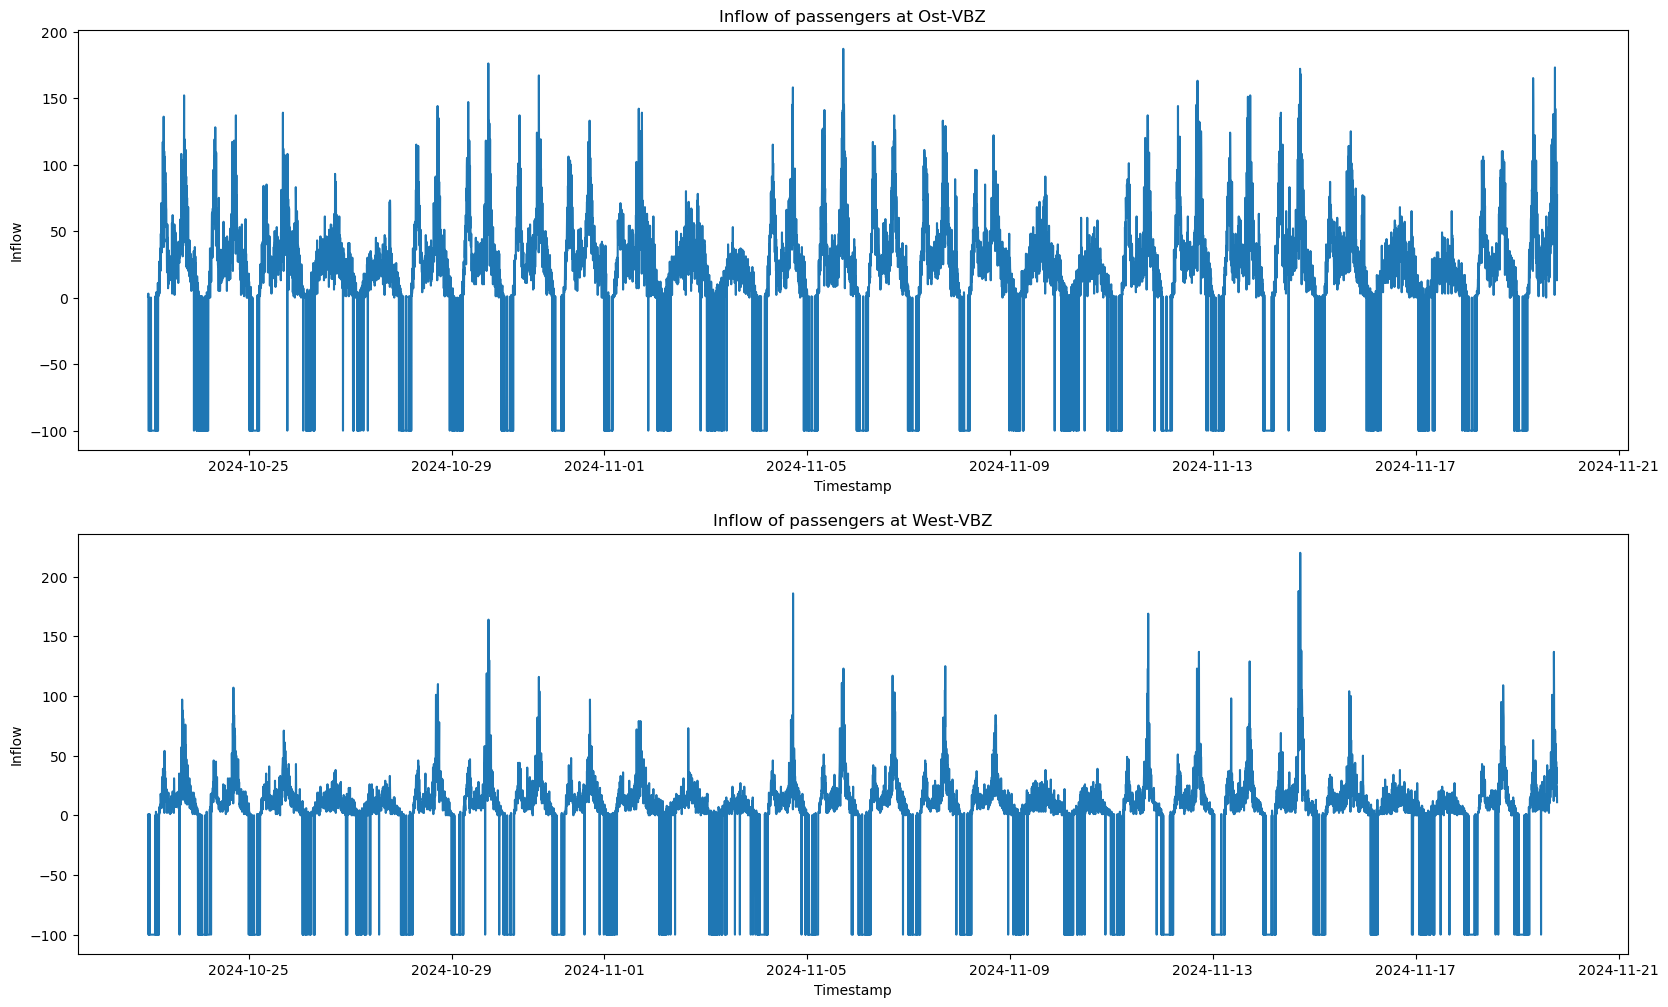

In [11]:
#Observe where missing values are located
healed_VBZ_mv = healed_VBZ.copy() #create a copy to work on
healed_VBZ_mv.fillna(-100, inplace = True) #Substitute missing values with negative value (impossible) in order to be able to identify them

#Plot the time series 
fig, axs = plt.subplots(2,1, figsize = (20, 12))
axs[0].plot(healed_VBZ_mv["Timestamp"].tail(8000), healed_VBZ_mv["Ost-VBZ Total"].tail(8000))
axs[0].set_xlabel("Timestamp")
axs[0].set_ylabel("Inflow")
axs[0].set_title("Inflow of passengers at Ost-VBZ")
axs[1].plot(healed_VBZ_mv["Timestamp"].tail(8000), healed_VBZ_mv["West-VBZ total"].tail(8000))
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Inflow")
axs[1].set_title("Inflow of passengers at West-VBZ")

### Dealing with missing values - Interpolation
Missing values seem to be distributed across the whole Timeseries and not concentrated in a single specific time interval. However, missing values seem to be appearing in a recurring pattern, with values missing regularly in the night hours comprised between 1 and 4 o' clock in the morning everyday. Despite this regularity, however, what happens at such an hour in the night isn't too relevant for the model prediction, since these hours where values are missing more often are typically hours during which there is no passengers in Hardbruecke. 

In order to obtain a cleaned Timeseries with equidistant observations, we can subsitute these missing values by interpolation, by taking the mean of the last and the next healthy datapoint available. Since we don't expect huge variations in the number of passengers occupying the station at such hours late in the night, the approximation should depict the reality faithfully enough.

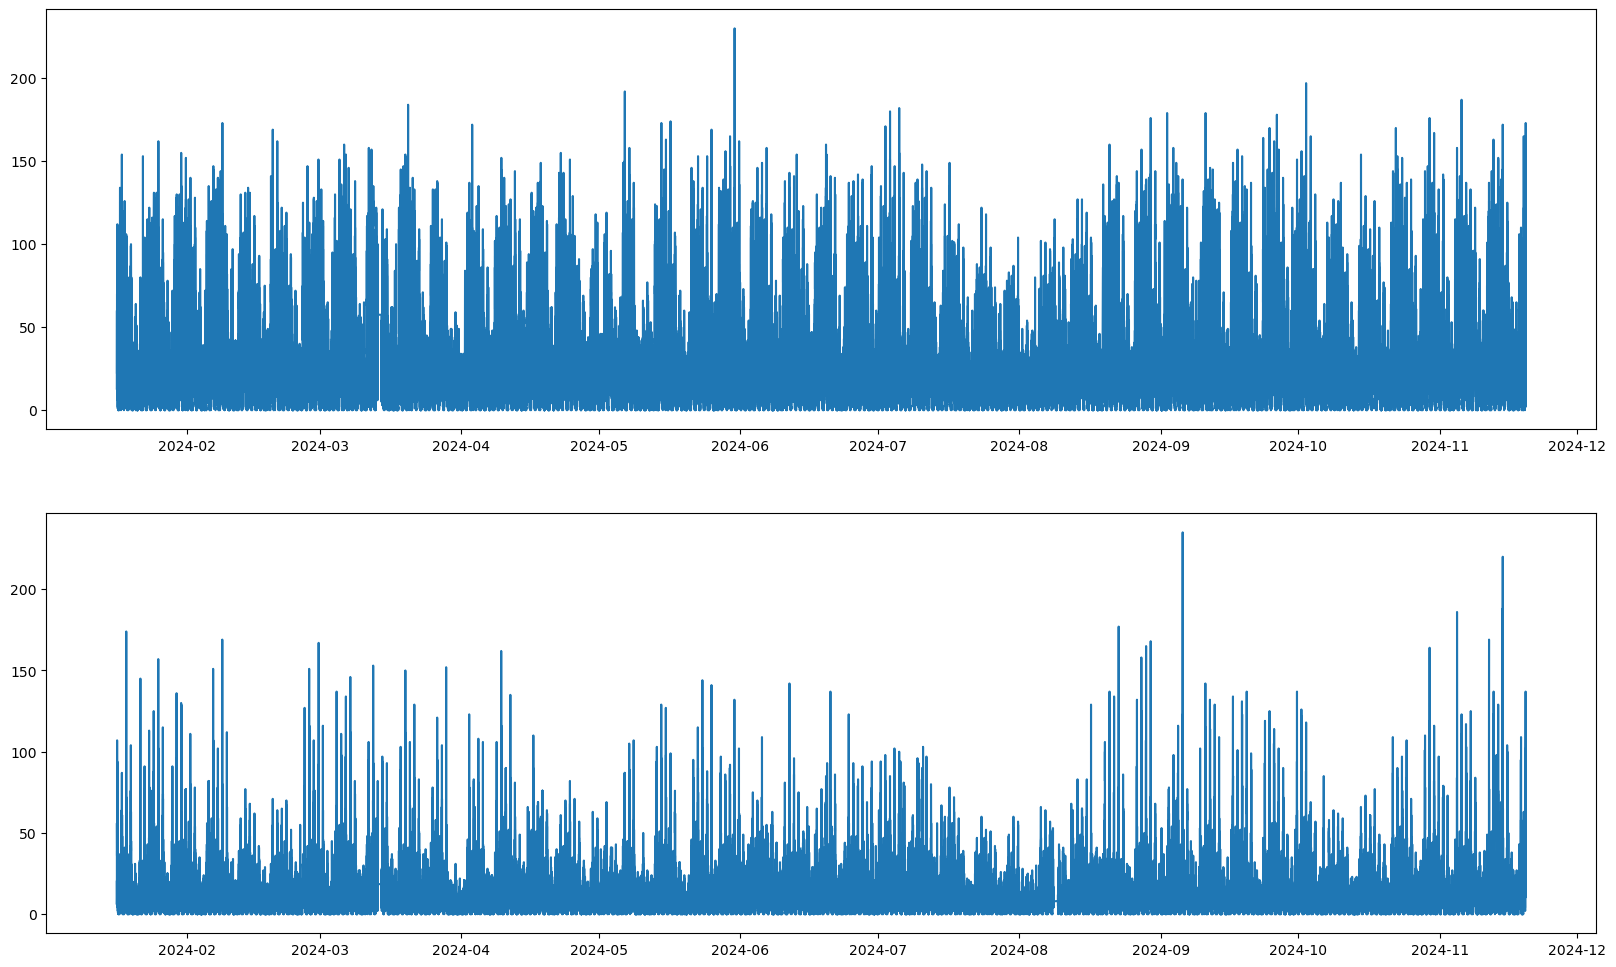

In [12]:
#Create columns with missing values substituted by interpolation, both by taking the value of the next healthy datapoint (forward fill)
# as well as by taking the value of the last available healthy datapoint (backward fill)
Ost_VBZ_Total_ff = healed_VBZ['Ost-VBZ Total'].ffill()
Ost_VBZ_Total_bf = healed_VBZ['Ost-VBZ Total'].bfill()

West_VBZ_total_ff = healed_VBZ['West-VBZ total'].ffill()
West_VBZ_total_bf = healed_VBZ['West-VBZ total'].bfill()

#Interpolate missing values by subsituting them by mean of forward and backward filling
healed_VBZ['Ost-VBZ Total'] = healed_VBZ['Ost-VBZ Total'].fillna((Ost_VBZ_Total_ff + Ost_VBZ_Total_bf) / 2)
healed_VBZ['West-VBZ total'] = healed_VBZ['West-VBZ total'].fillna((West_VBZ_total_ff + West_VBZ_total_bf) / 2)

#plot to see results
fig, axs = plt.subplots(2,1, figsize = (20, 12))
axs[0].plot(healed_VBZ["Timestamp"], healed_VBZ["Ost-VBZ Total"])
axs[1].plot(healed_VBZ["Timestamp"], healed_VBZ["West-VBZ total"])

### Cutting weather and VBZ datasets to let them have the same lenght

In [13]:
# Locate all observations after 16 january to match hardbrücke
#The hardbuecke Dataset has observations every five minutes starting from the 16th of January at 14:55
#Since we don't have data until the end of the current year yet, we can take all datapoints between 2024-01-16 14:55 and 2024-11-16 14:55
#to have exactly 10 months
healed_weather = healed_weather[healed_weather["Timestamp"] >= "2024-01-16 14:55:00"].reset_index(drop = True)
healed_weather = healed_weather[0:87841] #Cut healed_weather dataset for it to contain data from 16th of January 14:55 to the 16th of November 14:55
healed_VBZ = healed_VBZ[0:87841] #Do the same for healed_VBZ Dataset

#Check that the two datasets healed_weather and healed_VBZ have the same lenght
print(len(healed_VBZ) == len(healed_weather))

True


### Adding dummy variable for holidays and variable fo day name

In [14]:
#Dummy for holidays
#Define which days of the years are holidays
feiertage = pd.DataFrame({
	"Date": ["2024-01-01", "2024-01-02", "2024-03-28", "2024-03-29", "2024-04-01", "2024-04-15", "2024-05-01", "2024-05-08", "2024-05-09",
              "2024-05-10", "2024-05-20", "2024-08-01", "2024-09-09", "2024-12-24", "2024-12-25", "2024-12-26", "2024-12-27", "2024-12-30",
              "2024-12-31"]
})

feiertage["Date"] = pd.to_datetime(feiertage["Date"])
#Add value 1 (True) for holidays
feiertage["Holiday"] = 1

In [15]:
# Create date range for 2024
dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")

# Create a dataframe with names of the days of the week
calendar = pd.DataFrame({
    "Date": dates,
    "Day": dates.day_name()  
})
#Convert date column into datetime format
calendar["Date"] = pd.to_datetime(calendar["Date"])

#Initially assign value 0 (False) under the Holiday feature for all observations
calendar["Holiday"] = 0

# Put value 1 (True) under the Holiday feature for observations that correspond to those ones of feiertage
calendar2 = np.where(calendar["Date"].isin(feiertage["Date"]), 1, 0)
calendar["Holiday"] = calendar2

#Consider weekends as holidays as as well 
calendar.loc[calendar["Day"].isin(["Saturday", "Sunday"]), "Holiday"] = 1

#Extract only Date and Holiday column from the calendar Dataframe, since these ones are the features that we want to integrate in our data
holiday_df = calendar[["Date", "Holiday"]]

#Extend healed_holiday to match granularity of healed_VBZ
def extend_holidays(holiday_df):
    # Create a list to hold the expanded data
    extended_df = []
    
    for _, row in holiday_df.iterrows():
        
        date = pd.Timestamp(row['Date']).date()
        holiday_value = row['Holiday']
        
        # Generate 5-minute intervals for the whole day
        time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")
        
        # Append each timestamp with the holiday value
        extended_df.extend([(timestamp, holiday_value) for timestamp in time_range])
    
    # Create a new DataFrame from the expanded data
    holiday_df_extended = pd.DataFrame(extended_df, columns=["Timestamp", "Holiday"])
    return holiday_df_extended

healed_holiday = extend_holidays(holiday_df)

#Cutting healed_holiday to have the same lenght as healed_VB
healed_holiday = healed_holiday[4499:92340]

#Merge healed_holiday with healed_VBZ
healed_VBZ = pd.merge(healed_VBZ, healed_holiday, on = "Timestamp", how = "inner")

### Adding features for previous observations up to t-5

In [16]:
healed_VBZ.sort_values(by = "Timestamp",ascending=False, inplace = True)

#Add new variable for ost to shift values back
healed_VBZ["t-1 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-1)
healed_VBZ["t-2 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-2)
healed_VBZ["t-3 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-3)
healed_VBZ["t-4 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-4)
healed_VBZ["t-5 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-5)

#Add new variable for west to shift values back
healed_VBZ["t-1 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-1)
healed_VBZ["t-2 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-2)
healed_VBZ["t-3 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-3)
healed_VBZ["t-4 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-4)
healed_VBZ["t-5 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-5)

healed_VBZ.sort_values(by = "Timestamp",ascending=True, inplace = True)

### Merging Datasets together

In [17]:
#Merge the two dataframes weather and hardbruecke (healed_weather and healed_VBZ)
data = pd.merge(healed_VBZ, healed_weather, on = "Timestamp", how = "inner")

#Now that we included previous obsevations' values as features (up to t-5), there are, of course, new missing values for the first 5 
#observations. There is no data for these missing values, since we built this dataset by taking the first available value of the year 
#2024 from the hardbruecke dataset. To avoid problems in the modelling phase, we therefore drop the fist 5 observations :(
data = data[5:]

In [18]:
data

,Timestamp,Ost-VBZ Total,West-VBZ total,Holiday,t-1 Ost-VBZ,t-2 Ost-VBZ,t-3 Ost-VBZ,t-4 Ost-VBZ,t-5 Ost-VBZ,t-1 West-VBZ,...,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
5,2024-01-16 15:20:00,34.0,13.0,0,33.0,18.0,29.0,14.0,13.0,16.0,...,1.5,1.5,27.0,3.7,962.4,0.0,-2.6,147.0,61.0,405.79
6,2024-01-16 15:25:00,54.0,10.0,0,34.0,33.0,18.0,29.0,14.0,13.0,...,1.5,1.5,27.0,3.7,962.4,0.0,-2.6,147.0,61.0,405.79
7,2024-01-16 15:30:00,47.0,56.0,0,54.0,34.0,33.0,18.0,29.0,10.0,...,1.6,1.6,33.0,3.8,962.3,0.0,-2.6,133.0,60.0,405.79
8,2024-01-16 15:35:00,42.0,16.0,0,47.0,54.0,34.0,33.0,18.0,56.0,...,1.6,1.6,33.0,3.8,962.3,0.0,-2.6,133.0,60.0,405.79
9,2024-01-16 15:40:00,60.0,44.0,0,42.0,47.0,54.0,34.0,33.0,16.0,...,1.5,1.5,72.0,3.0,962.3,0.0,-2.7,105.0,61.0,405.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87836,2024-11-16 14:35:00,44.0,3.0,1,35.0,19.0,55.0,17.0,58.0,12.0,...,1.2,1.2,118.0,9.8,973.9,0.0,4.4,207.0,69.0,405.88
87837,2024-11-16 14:40:00,30.0,19.0,1,44.0,35.0,19.0,55.0,17.0,3.0,...,1.0,1.0,109.0,9.8,973.8,0.0,4.0,191.0,67.0,405.88
87838,2024-11-16 14:45:00,16.0,18.0,1,30.0,44.0,35.0,19.0,55.0,19.0,...,1.0,1.0,109.0,9.8,973.8,0.0,4.0,191.0,67.0,405.88
87839,2024-11-16 14:50:00,52.0,6.0,1,16.0,30.0,44.0,35.0,19.0,18.0,...,0.9,0.9,151.0,9.5,973.7,0.0,4.2,174.0,69.0,405.88


# Modelling phase - Random Forest

In [19]:
#Define Design matrix and outcome variables
y_ost = data["Ost-VBZ Total"]
y_west = data["West-VBZ total"]

exclude_columns_ost = ["Timestamp", 
                       "Ost-VBZ Total", 
                       "West-VBZ total", 
                       "t-1 West-VBZ", 
                       "t-2 West-VBZ", 
                       "t-3 West-VBZ", 
                       "t-4 West-VBZ", 
                       "t-5 West-VBZ"]
exclude_columns_west = ["Timestamp", 
                       "Ost-VBZ Total", 
                       "West-VBZ total", 
                       "t-1 Ost-VBZ", 
                       "t-2 Ost-VBZ", 
                       "t-3 Ost-VBZ", 
                       "t-4 Ost-VBZ", 
                       "t-5 Ost-VBZ"]

X_ost = data.drop(columns = exclude_columns_ost)
X_west = data.drop(columns = exclude_columns_west)

#Split into training and test data 
from sklearn.model_selection import train_test_split

X_ost_train, X_ost_test, y_ost_train, y_ost_test = train_test_split(X_ost, y_ost, shuffle = False, test_size = 0.2)
X_west_train, X_west_test, y_west_train, y_west_test = train_test_split(X_west, y_west, shuffle = False, test_size = 0.2)

### Predicting inflow of passengers in Ost

In [20]:
#Import RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

RF_ost = RandomForestRegressor(n_estimators = 100, random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_ost.fit(X_ost_train, y_ost_train)

#Predict for train set
y_ost_predict_train = RF_ost.predict(X_ost_train)
y_ost_predict_test = RF_ost.predict(X_ost_test)

# Import the mean_squared_error function under the alias mse
from sklearn.metrics import mean_squared_error as mse

#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_predict_train))
print("Ost Test MSE:", mse(y_ost_test, y_ost_predict_test))

Ost Train MSE: 25.621544842671096
Ost Test MSE: 206.14033956706476


In [21]:
RF_west = RandomForestRegressor(n_estimators = 100, random_state = 72)

#Train RandomForest Regressor for West
RF_west.fit(X_west_train, y_west_train)

#Predict for train and test sets
y_west_predict_train = RF_west.predict(X_west_train)
y_west_predict_test = RF_west.predict(X_west_test)

#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_predict_train))
print("West Test MSE:", mse(y_west_test, y_west_predict_test))

West Train MSE: 9.507549014853245
West Test MSE: 82.26994498892752


### Performance of the RandomForest
Letting a RandomForest algorithm run withough tuning any parameter leads to estimations that might not be too accurate. 
- For the Bus Stop Hardbruecke with direction Schiffbau (Ost) the RandomForest performs somewhat decently (MSE = 25,6) in the trainset but very poorly in the test set (MSE = 206,14).
- FOR THE Bus Stop Hardbruecke with direction with direction Hardplatz the RandomForest performs far better. The MSE for the predictions on the Training set is 9,51 and for the Test set is about 82,27.

In both cases, the MSE is severely higher for the Testset, hinting towards an overfitting of the model. We can tune the hyperparamters of the model to try achieve a better estimate.

Text(0.5, 1.0, 'Test Set Ost')

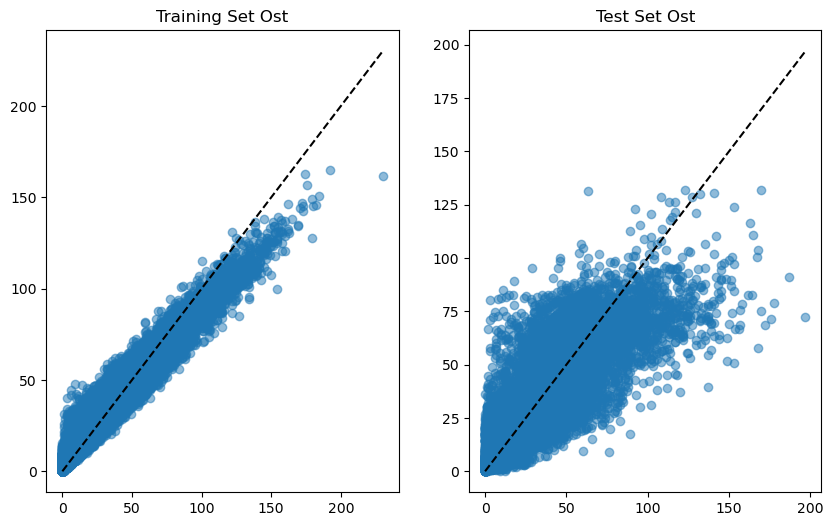

In [22]:
# Plot our predictions for Ost data
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data Ost
axs[0].scatter(y_ost_train, y_ost_predict_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_ost_train.min(), y_ost_predict_train.min()), 
               np.maximum(y_ost_train.max(), y_ost_predict_train.max())] for _ in range(2)],
              color = "black", ls="--")
axs[0].set_title("Training Set Ost")

# Plot the test data Ost
axs[1].scatter(y_ost_test, y_ost_predict_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_ost_test.min(), y_ost_predict_test.min()), 
               np.maximum(y_ost_test.max(), y_ost_predict_test.max())] for _ in range(2)],
              color = "black", ls="--")
axs[1].set_title("Test Set Ost")

### Hyperparameter tuning of the RandomForest

In [23]:
 # Run random forest again by setting max_feature = "sqrt"
RF_ost_t = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72)

#Train RandomForest on Training Set for Ost
RF_ost_t.fit(X_ost_train, y_ost_train)

#Predict for train and test set
y_ost_pred_train = RF_ost_t.predict(X_ost_train)
y_ost_pred_test = RF_ost_t.predict(X_ost_test)

#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_pred_train))
print("Ost Test MSE:", mse(y_ost_test, y_ost_pred_test))

Ost Train MSE: 24.53982926236526
Ost Test MSE: 205.8311811778232


In [ ]:
RF_west_t = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72)

#Train RandomForest on Training Set for west
RF_west_t.fit(X_west_train, y_west_train)

#Preidct for train and test sets
y_west_pred_train = RF_west_t.predict(X_west_train)
y_west_pred_test = RF_west_t.predict(X_west_test)

#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_pred_train))
print("West Test MSE:", mse(y_west_test, y_west_pred_test))